In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

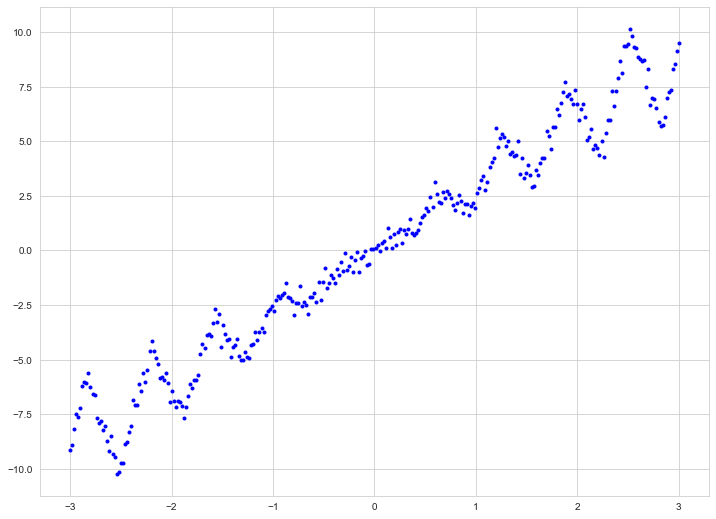

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

Немного поменяла функцию, чтобы отображать ожидаемое и реальное на одном графике и глубину дерева

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12, rotation=90)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    plt.plot(X, y, linewidth=2, label="y")
    plt.legend()
    
    plt.subplots_adjust(wspace=0.5)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

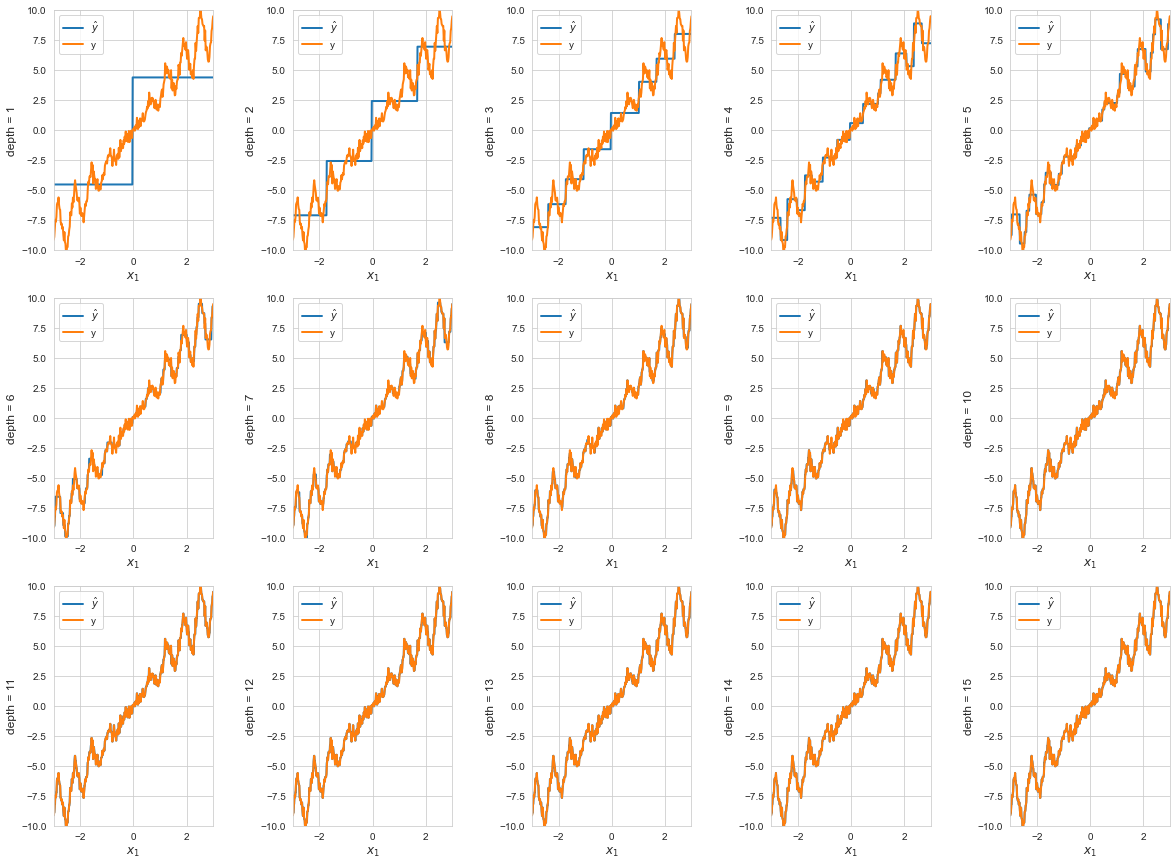

In [6]:
x_size = 5
y_size = 3
fig, axes = plt.subplots(y_size, x_size, figsize = (20, 15))

for depth in range(1, 16):
    ax = plt.subplot(y_size, x_size, depth)
    dt_reg = DecisionTreeRegressor(max_depth=depth)
    dt_reg.fit(X,y)
    plot_regression_predictions(dt_reg, X, y, ylabel=f"depth = {depth}")

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

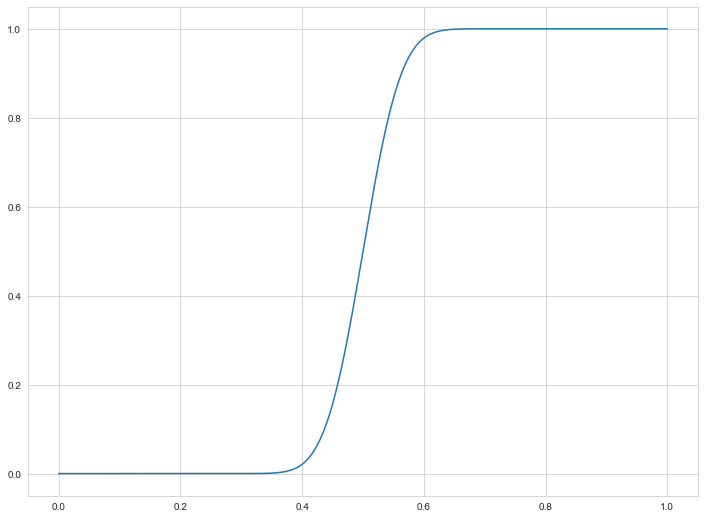

In [7]:
from math import comb

def mean_majority(p, num=101):
    m = 0
    majority = num // 2 + num % 2
    for i in range(majority, num + 1):
        m = m + comb(num, i) * (p ** i) * ((1 - p) ** (num - i))
    return m

p_values = np.linspace(0, 1, 1000)
mean_majority_for_p = [mean_majority(p, 101) for p in p_values]
plt.plot(p_values, mean_majority_for_p);

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

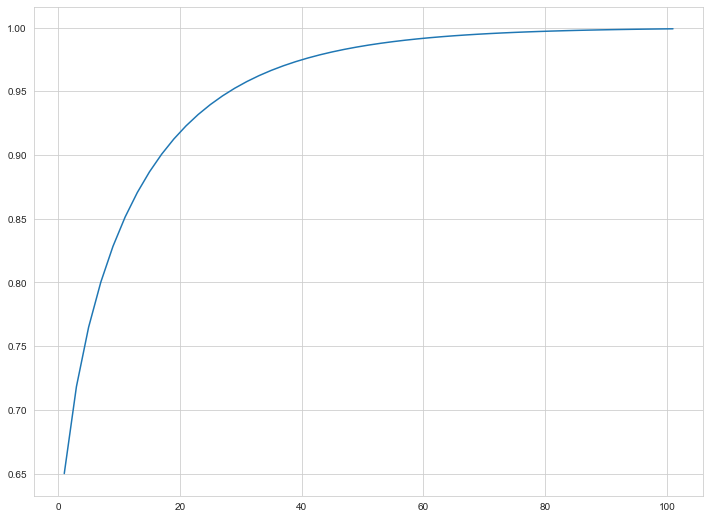

In [9]:
num_values = np.linspace(1, 101, 51).astype('int64')
mean_majority_for_p = [mean_majority(p=0.65, num=num) for num in num_values]
plt.plot(num_values, mean_majority_for_p);

Опишите ваши наблюдения:

* Для 101 классификатора достаточно вероятности p ~= 0.65, чтобы получить вероятность предсказания по большинству голосов с вероятностью ~= 1.0
* С фиксированной вероятностью p ~= 0.65 вероятность предсказания по большинству голосов растет с увеличением числа классификаторов и достигает значение близкое к 1.0 в районе 101 классификатора

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(0, self.n_estimators):
            np.random.seed(self.random_state + i)
            feature_idx = np.random.choice(X.shape[1], size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feature_idx) 
            bootstrap_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_bootstrap = X[bootstrap_idx][:, feature_idx]
            y_bootstrap = y[bootstrap_idx]
            classifier = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            classifier.fit(X_bootstrap, y_bootstrap)
            self.trees.append(classifier)
        return self

    def predict_proba(self, X):
        probas = []
        for i in range(0, self.n_estimators):
            probas.append(self.trees[i].predict_proba(X[:, self.feat_ids_by_tree[i]]))
        return np.mean(probas, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

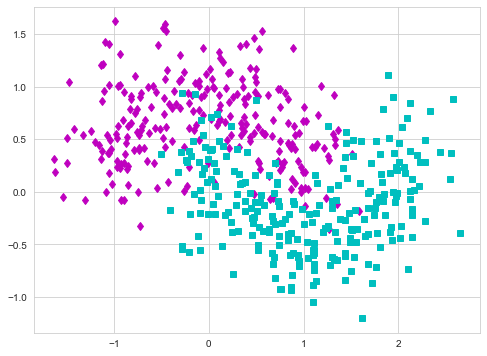

In [152]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "md")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "cs")
plt.show()

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [155]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
classifier = RandomForestClassifierCustom()
parameters = {'max_depth': [1, 5, 10, 15], 'n_estimators' : [5, 10, 15, 17, 20, 25], 'max_features' : [2], 'random_state' : [SEED]}
scoring = 'roc_auc'

grid_classifier = GridSearchCV(estimator=classifier, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring)
grid_classifier.fit(X_train, y_train)
print(f"The best parameters across ALL searched params: {grid_classifier.best_params_}")

The best parameters across ALL searched params: {'max_depth': 5, 'max_features': 2, 'n_estimators': 20, 'random_state': 111}


Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

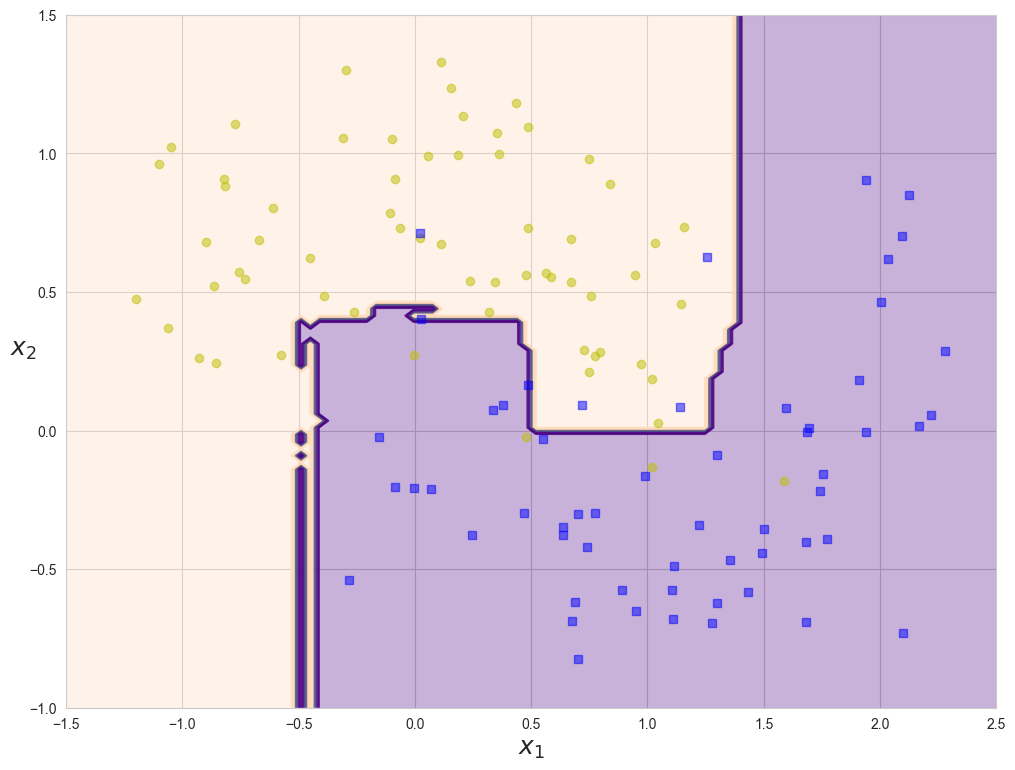

In [157]:
rfc = RandomForestClassifierCustom(n_estimators=20, max_depth=5, max_features=2, random_state=SEED)
rfc.fit(X_train, y_train)
plot_decision_boundary(rfc, X_test, y_test)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [159]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [160]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

pearsonr max : 0.957299923931901
pearsonr min : 0.6102193734298615


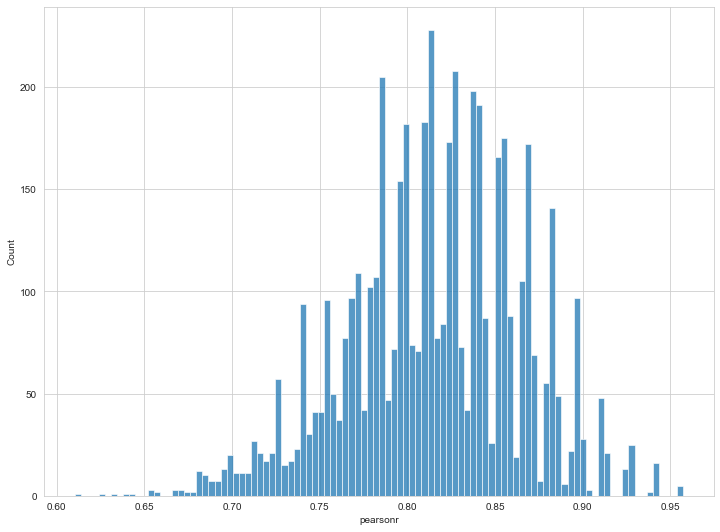

In [161]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
corrs = base_model_pair_correlation(classifier, X_test)

sns.histplot(corrs, bins=100);
plt.xlabel("pearsonr");

print(f"pearsonr max : {np.max(corrs)}")
print(f"pearsonr min : {np.min(corrs)}")

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [20]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

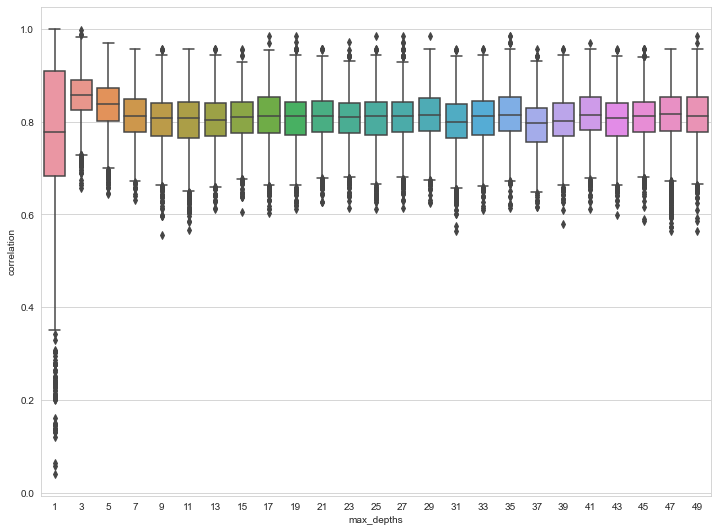

In [162]:
coors_matrix = []
max_depths = range(1, 50, 2)
for max_depth in max_depths:
    classifier = RandomForestClassifier(max_depth=max_depth)
    classifier.fit(X_train, y_train)
    coors_matrix.append(base_model_pair_correlation(classifier, X_test))
    
coors_df = pd.DataFrame(coors_matrix, index=max_depths).transpose()

sns.boxplot(data=coors_df);
plt.xlabel("max_depths");
plt.ylabel("correlation");

Опишите ваши наблюдения:

* Предсказания моделей имеют значения коэффициента Пирсона в районе от 0.63 до 0.97  
* Предсказания не очень глубоких деревьев (max_depth до 6) скоррелированы сильнее, чем предсказания более глубоких деревьев, но коэффициент корреляции выходит на плато с увеличеним глубины, поэтому сильно увеличивать глубину нет большого смысла. Тем более это приведет к переобучению. Итого, оптимальной глубиной можно назвать 7 или 8.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [137]:
heart_dataset = pd.read_csv("data/heart.csv")

*формируем себе данные из выборки*

In [138]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


In [139]:
heart_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [81]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [82]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [28]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [83]:
voting_hard.fit(X_train, y_train);
voting_soft.fit(X_train, y_train);

corrs_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)
print("voting_hard : ")
for corrs in corrs_hard:
    print(f"{corrs[0].__class__.__name__} ---- {corrs[1].__class__.__name__}, corr: {corrs[2]}")

print("voting_soft : ")
corrs_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
for corrs in corrs_soft:
    print(f"{corrs[0].__class__.__name__} ---- {corrs[1].__class__.__name__}, corr: {corrs[2]}")

voting_hard : 
DecisionTreeClassifier ---- RandomForestClassifier, corr: 0.8134894007824365
DecisionTreeClassifier ---- ExtraTreesClassifier, corr: 0.7749544834941164
DecisionTreeClassifier ---- KNeighborsClassifier, corr: 0.3133294966283545
DecisionTreeClassifier ---- SVC, corr: 0.7153743909950713
DecisionTreeClassifier ---- SVC, corr: 0.2820135356695378
DecisionTreeClassifier ---- CatBoostClassifier, corr: 0.7875690140798687
DecisionTreeClassifier ---- LGBMClassifier, corr: 0.8282760696670941
DecisionTreeClassifier ---- LGBMClassifier, corr: 0.861265642888772
DecisionTreeClassifier ---- XGBClassifier, corr: 0.804966685796174
DecisionTreeClassifier ---- XGBRFClassifier, corr: 0.8857896825439961
DecisionTreeClassifier ---- LogisticRegression, corr: 0.7399818214388802
DecisionTreeClassifier ---- GaussianNB, corr: 0.6827714012201819
RandomForestClassifier ---- ExtraTreesClassifier, corr: 0.9215651183028868
RandomForestClassifier ---- KNeighborsClassifier, corr: 0.39241674265645554
Random

*много пар с высокой корреляцией*

In [130]:
def experiment(base_models):
    voting_hard = VotingClassifier(estimators=base_models, voting='hard')
    voting_soft = VotingClassifier(estimators=base_models, voting='soft')

    for model in [voting_hard, voting_soft]: 
        scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
        print(f"{model.__class__.__name__}: {scores.mean()}")
    

*начинаем рубрику ЭЭЭЭЭксперименты...*

In [131]:
base_models_1 = [("DT", dt), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

experiment(base_models_1)

VotingClassifier: 0.8453489599831063
VotingClassifier: 0.8455110375195781


In [35]:
base_models_2 = [("DT", dt), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_2)

VotingClassifier: 0.8527055600226333
VotingClassifier: 0.8455110375195781


In [36]:
base_models_3 = [("DT", dt), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_3)

VotingClassifier: 0.8527055600226333
VotingClassifier: 0.8503633581946834


In [37]:
base_models_4 = [("DT", dt), 
               ("ETC", etc), ("KNN", knn), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_4)

VotingClassifier: 0.8440383154238577
VotingClassifier: 0.8490813069126322


In [38]:
base_models_5 = [("RF", rf), ("SVC_LIN", svc_lin),
               ("LGBM", lgbm), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_5)

VotingClassifier: 0.829842598952598
VotingClassifier: 0.8294258671715905


In [39]:
base_models_6 = [("RF", rf),
               ("LGBM", lgbm), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_6)

VotingClassifier: 0.8271062271062272
VotingClassifier: 0.8275329125002328


In [40]:
base_models_6 = [("RF", rf),
               ("LGBM", lgbm), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_6)

VotingClassifier: 0.8271062271062272
VotingClassifier: 0.8275329125002328


In [41]:
base_models_7 = [("DT", dt),
               ("ETC", etc),
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr), ("NB", nb)]

experiment(base_models_7)

VotingClassifier: 0.8555555555555555
VotingClassifier: 0.8539876113046846


In [42]:
base_models_8 = [
               ("ETC", etc),
               ("CAT", cat),
               ("LR", lr), ("NB", nb)]

experiment(base_models_8)

VotingClassifier: 0.8341313305168727
VotingClassifier: 0.8436972971596948


In [86]:
base_models_9 = [
               ("CAT", cat),
               ("LR", lr)]

experiment(base_models_9)

VotingClassifier: 0.8254668013704158
VotingClassifier: 0.8694543828264759


In [141]:
base_models_10 = [ 
               ("SVC_LIN", svc_lin), 
               ("CAT", cat), ("LR", lr), ]

experiment(base_models_10)

VotingClassifier: 0.847364126578686
VotingClassifier: 0.8627026267427929


*Лучшее из того что удалось получить - 0.862. Далековато от 0.91, видим что простым перебором не получилось и надо пробовать что-то другое...*

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [46]:
pd.set_option('display.max_columns', None)
data = pd.read_csv("data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [48]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Account Length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area Code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
VMail Message,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Day Mins,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Day Calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Day Charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
Eve Mins,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
Eve Calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
Eve Charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
Night Mins,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


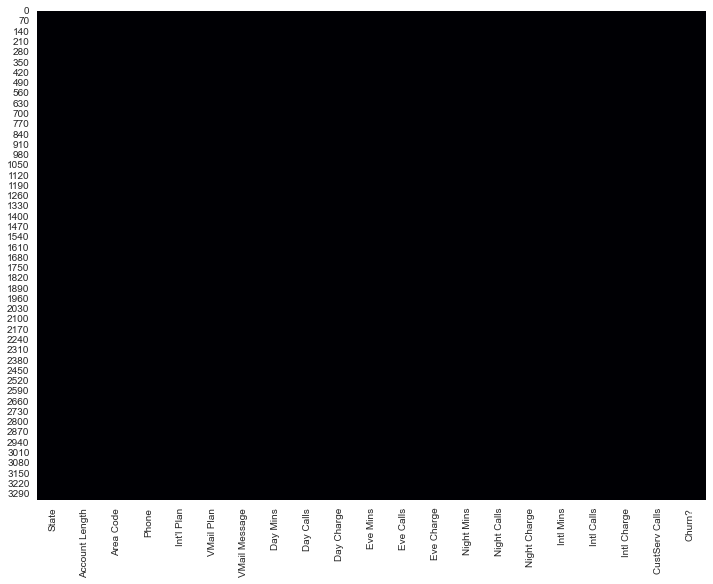

In [49]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

*нет нулей, ура!*

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1 = data.copy(deep = True)
text_data_features = [i for i in list(data.columns) if i not in list(data.describe().columns)]

print('Label Encoder Transformation')
for i in text_data_features :
    df1[i] = le.fit_transform(df1[i])
    print(i, ' : ', df1[i].unique(), ' = ', le.inverse_transform(df1[i].unique()))

Label Encoder Transformation
State  :  [16 35 31 36  1 19 24 18 49 15 39 12 26 34 13 46 45 43  9  5  3 40 29 50
 11 14 30 10  0 20  2 48 37 22  8 44  4 23 41 27 47 32 33  7 17 21 25 42
 38  6 28]  =  ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
Phone  :  [1926 1575 1117 ...   42 1331 2559]  =  ['382-4657' '371-7191' '358-1921' ... '328-8230' '364-6381' '400-4344']
Int'l Plan  :  [0 1]  =  ['no' 'yes']
VMail Plan  :  [1 0]  =  ['yes' 'no']
Churn?  :  [0 1]  =  ['False.' 'True.']


In [51]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
State,3333.0,26.059406,14.824911,0.00,14.00,26.00,39.00,50.00
Account Length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area Code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
Phone,3333.0,1666.000000,962.298550,0.00,833.00,1666.00,2499.00,3332.00
Int'l Plan,3333.0,0.096910,0.295879,0.00,0.00,0.00,0.00,1.00
VMail Plan,3333.0,0.276628,0.447398,0.00,0.00,0.00,1.00,1.00
VMail Message,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Day Mins,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Day Calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Day Charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64


*немножко препроцессинга*

In [52]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler()
ss = StandardScaler()

df1.drop(columns = ['Phone', 'Account Length'], inplace = True)

df1['State'] = mms.fit_transform(df1[['State']])
df1['Area Code'] = mms.fit_transform(df1[['Area Code']])
df1['VMail Message'] = mms.fit_transform(df1[['VMail Message']])
df1['Day Mins'] = mms.fit_transform(df1[['Day Mins']])
df1['Day Calls'] = mms.fit_transform(df1[['Day Calls']])
df1['Day Charge'] = mms.fit_transform(df1[['Day Charge']])
df1['Eve Mins'] = mms.fit_transform(df1[['Eve Mins']])
df1['Eve Calls'] = mms.fit_transform(df1[['Eve Calls']])
df1['Eve Charge'] = mms.fit_transform(df1[['Eve Charge']])
df1['Night Mins'] = mms.fit_transform(df1[['Night Mins']])
df1['Night Calls'] = mms.fit_transform(df1[['Night Calls']])
df1['Night Charge'] = mms.fit_transform(df1[['Night Charge']])
df1['Intl Mins'] = mms.fit_transform(df1[['Intl Mins']])
df1['Intl Calls'] = mms.fit_transform(df1[['Intl Calls']])
df1['Intl Charge'] = mms.fit_transform(df1[['Intl Charge']])
df1['CustServ Calls'] = mms.fit_transform(df1[['CustServ Calls']])
df1.head()

,State,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,0.32,0.068627,0,1,0.490196,0.755701,0.666667,0.755701,0.542755,0.582353,0.542866,0.595750,0.408451,0.595935,0.500,0.15,0.500000,0.111111,0
1,0.70,0.068627,0,1,0.509804,0.460661,0.745455,0.460597,0.537531,0.605882,0.537690,0.621840,0.492958,0.622236,0.685,0.15,0.685185,0.111111,0
2,0.62,0.068627,0,0,0.000000,0.693843,0.690909,0.693830,0.333242,0.647059,0.333225,0.374933,0.500000,0.375374,0.610,0.25,0.609259,0.000000,0
3,0.70,0.000000,1,0,0.000000,0.853478,0.430303,0.853454,0.170195,0.517647,0.170171,0.467187,0.394366,0.467424,0.330,0.35,0.329630,0.222222,0
4,0.72,0.068627,1,0,0.000000,0.475200,0.684848,0.475184,0.407754,0.717647,0.407959,0.440290,0.619718,0.440526,0.505,0.15,0.505556,0.333333,0


In [164]:
#!pip install imbalanced-learn

import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE

*уравновешиваем выборки ушедших и неушедших*

In [56]:
over = SMOTE(sampling_strategy = 1)

f1 = df1.iloc[:,:18].values
t1 = df1.iloc[:,18].values

f1, t1 = over.fit_resample(f1, t1)
Counter(t1)

Counter({0: 2850, 1: 2850})

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold

In [58]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size=0.20, random_state=2)

In [59]:
def model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) не будем менять cv
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv=3, scoring='f1').mean()))

def model_evaluation(classifier, x_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(x_test))
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot = labels, cmap = 'Blues', fmt ='')
    print(classification_report(y_test, classifier.predict(x_test)))

In [60]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000)
model(classifier_xgb, x_train, y_train, x_test, y_test)

Cross Validation Score :  93.96%


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       568
           1       0.95      0.93      0.94       572

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



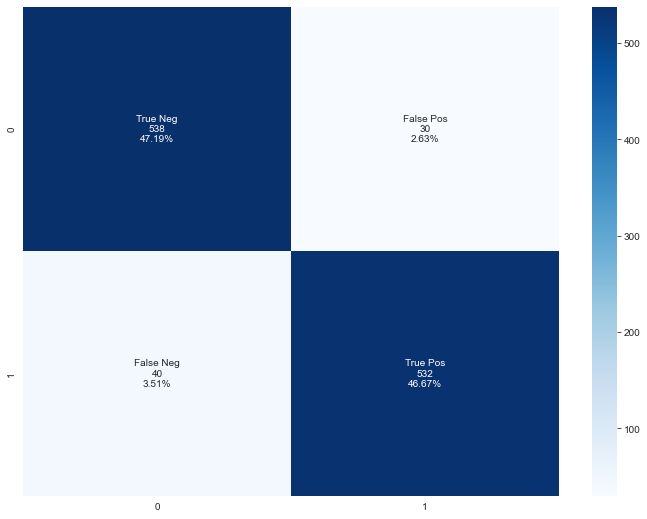

In [61]:
model_evaluation(classifier_xgb, x_test, y_test)

In [62]:
from lightgbm import LGBMClassifier

classifier_lgbm = LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000)

In [63]:
model(classifier_lgbm, x_train, y_train, x_test, y_test)

Cross Validation Score :  94.39%


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       568
           1       0.95      0.94      0.94       572

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



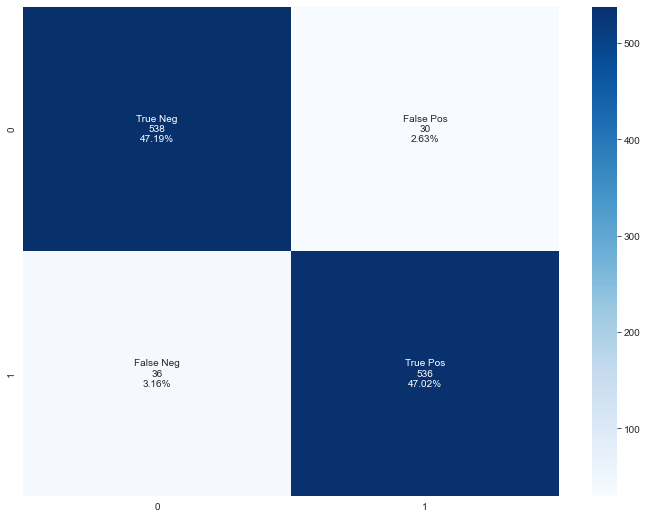

In [64]:
model_evaluation(classifier_lgbm, x_test, y_test)

In [65]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('classifier_xgb',classifier_xgb),
                                         ('classifier_lgbm',classifier_lgbm)],
                           final_estimator = classifier_lgbm)

In [66]:
model(stack, x_train, y_train, x_test, y_test)

Cross Validation Score :  94.42%


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       568
           1       0.95      0.94      0.94       572

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



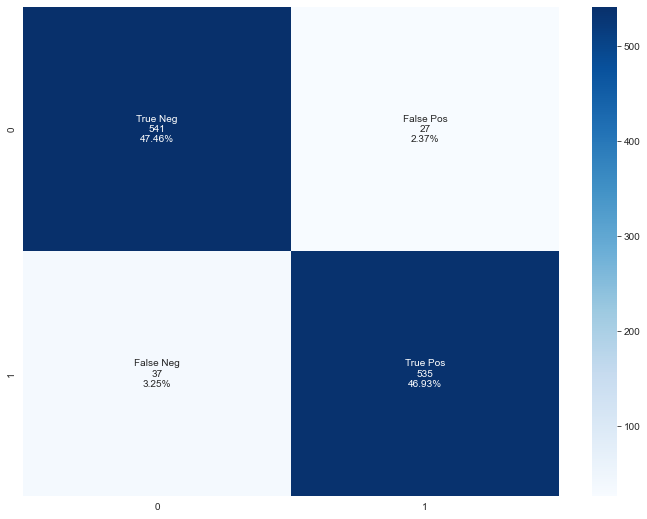

In [67]:
model_evaluation(stack, x_test, y_test)

In [68]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

In [69]:
model(cat, x_train, y_train, x_test, y_test)

Cross Validation Score :  96.66%


*мой максимум*

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       568
           1       0.98      0.96      0.97       572

    accuracy                           0.97      1140
   macro avg       0.97      0.97      0.97      1140
weighted avg       0.97      0.97      0.97      1140



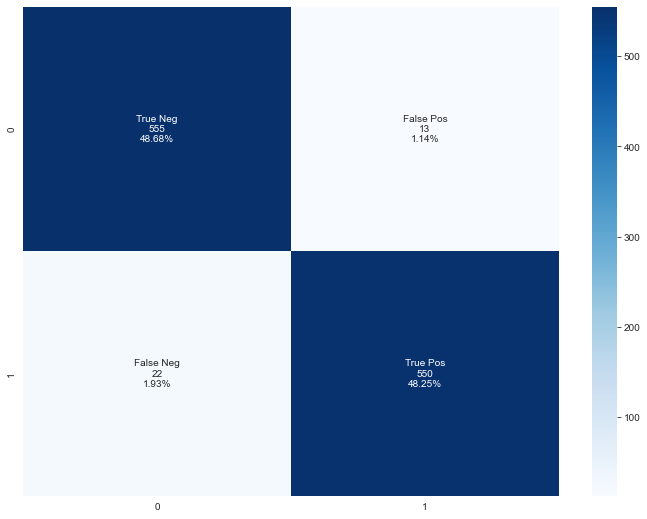

In [70]:
model_evaluation(cat, x_test, y_test)

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
я тоже не умею, это Пушной)

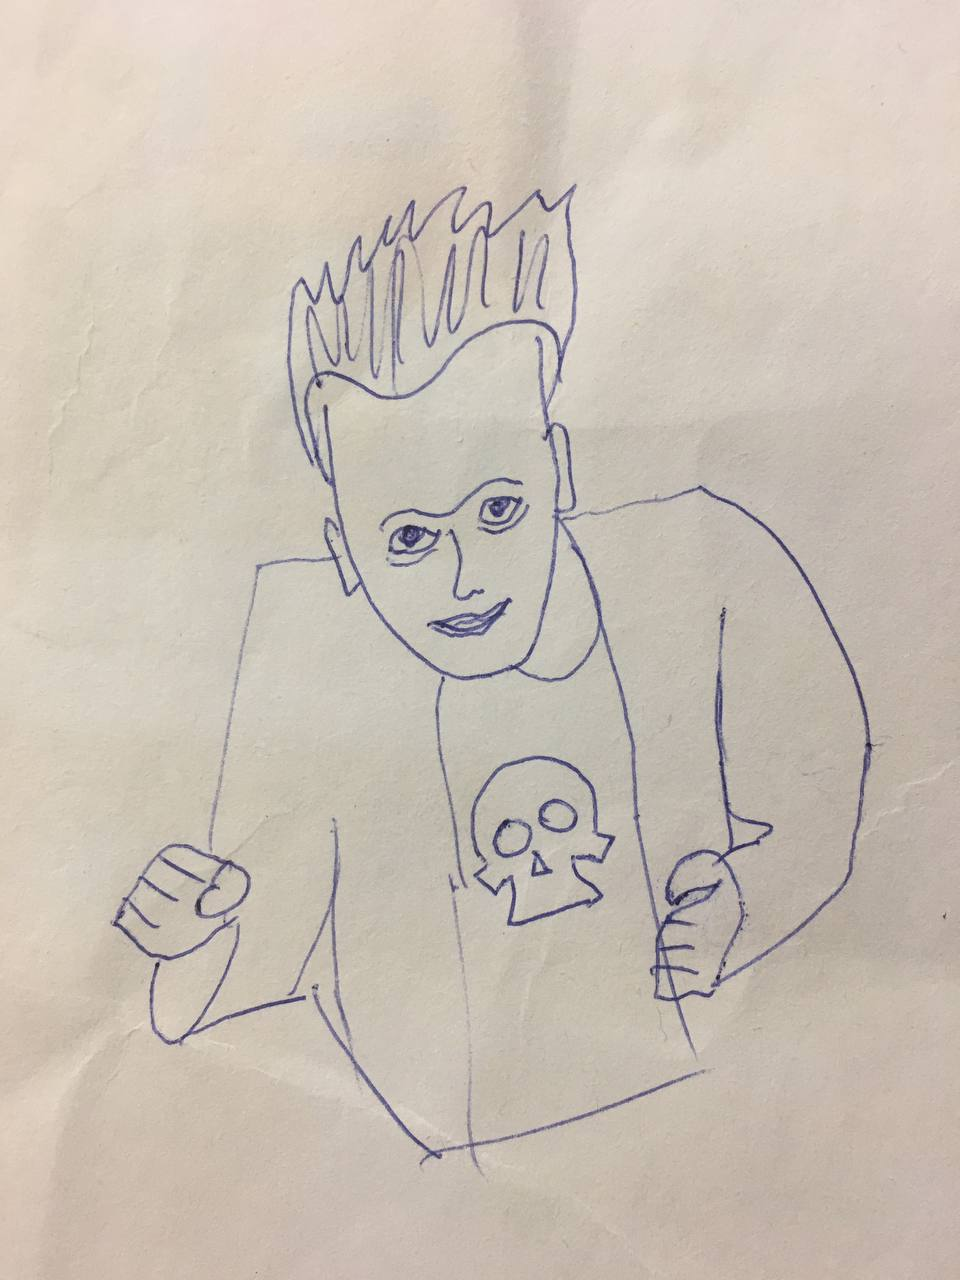

In [136]:
from IPython.display import Image
Image("data/eeeexperiment.jpg", width=320, height=240) 


### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Поддерживаю некоторого оратора из чата - хочется все-таки понять, как бы получить скор ближе к 0.91 в 3 задании :)